<a href="https://colab.research.google.com/github/mostaking/Scene-text-detection-using-yolo-and-guaussian-heatmapping/blob/main/Scene_text_detection_using_yolo_and_guaussian_heatmapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd

/root


In [ ]:
!git clone https://github.com/Neerajj9/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow.git

fatal: destination path 'Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow' already exists and is not an empty directory.


In [ ]:
cd Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow

/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras import backend as K
import keras
import cv2
from Utils import *
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os
import datetime
from math import exp
from PIL import Image

In [ ]:
img_w = 512
img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16
#Images Cropped. 
cropped_images = []

In [ ]:
!pip install gdown
!pip install -q pyyaml h5py
!pip install pillow

In [ ]:
#dataset download
!gdown https://drive.google.com/u/0/uc?id=1ObrV9pbH_-LBGbIodWgB6W4dtQloTTH6&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1ObrV9pbH_-LBGbIodWgB6W4dtQloTTH6
To: /root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/Data.tar.gz
100% 259M/259M [00:02<00:00, 118MB/s]


In [ ]:
cd

/root


In [ ]:
!mkdir ~/Data1
#pa = "Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/"
!tar -xvf "/root/Data.tar.gz" -C "/root/Data1/"     #[run this cell to extract tar files]

mkdir: cannot create directory ‘/root/Data1’: File exists
images/img_58.jpg
images/img_228.jpg
ground_truth/gt_109.txt
images/243.jpg
images/278.jpg
images/img_45.jpg
images/321.jpg
images/img_115.jpg
ground_truth/gt_266.txt
ground_truth/gt_img_68.txt
images/img_23.jpg
images/196.jpg
ground_truth/gt_231.txt
ground_truth/gt_img_33.txt
images/img_34.jpg
images/161.jpg
ground_truth/gt_184.txt
images/img_126.jpg
images/img_69.jpg
images/289.jpg
images/img_137.jpg
images/img_190.jpg
images/img_204.jpg
images/254.jpg
ground_truth/gt_277.txt
ground_truth/gt_img_79.txt
ground_truth/gt_img_170.txt
ground_truth/gt_img_106.txt
ground_truth/gt_320.txt
ground_truth/gt_242.txt
ground_truth/gt_img_44.txt
images/img_148.jpg
images/108.jpg
images/172.jpg
ground_truth/gt_195.txt
ground_truth/gt_209.txt
images/230.jpg
images/img_215.jpg
ground_truth/gt_160.txt
ground_truth/gt_img_6.txt
images/265.jpg
ground_truth/gt_288.txt
ground_truth/gt_img_181.txt
ground_truth/gt_img_117.txt
images/img_102.jpg
ground

In [ ]:
!python /root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/Preprocess.py

100% 461/461 [00:00<00:00, 116698.30it/s]
100% 461/461 [00:26<00:00, 17.19it/s]
tcmalloc: large alloc 2900361216 bytes == 0x562dd8646000 @  0x7fd73017e1e7 0x7fd72dd3e46e 0x7fd72dd8ec7b 0x7fd72dd8ed18 0x7fd72de4ad79 0x7fd72de4de4c 0x7fd72df6ce7f 0x7fd72df72fb5 0x7fd72df74e3d 0x7fd72df76516 0x562da7d2b720 0x562da7d2b2f9 0x7fd72de550db 0x562da7e14113 0x562da7d9a62d 0x562da7d989ee 0x562da7d986f3 0x562da7e624c2 0x562da7e6283d 0x562da7e626e6 0x562da7e3a163 0x562da7e39e0c 0x7fd72ef68bf7 0x562da7e39cea


In [ ]:
#import data
#X and Y numpy arrays are created using the Prepocess.py file
X = np.load('Data1/X.npy')
Y = np.load('Data1/Y.npy')

In [ ]:
print(X.shape , Y.shape)

(461, 512, 512, 3) (461, 16, 16, 1, 5)


In [ ]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)

In [ ]:
def save_model(model):
    model_json = model.to_json()
    with open("/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

        
        
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    

In [ ]:
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation=tf.nn.leaky_relu , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation=tf.nn.leaky_relu , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation=tf.nn.leaky_relu , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model


In [ ]:
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss


In [ ]:
#Downloading The weights. 
!gdown https://drive.google.com/u/0/uc?id=1OwrEu6SeaNM3l_clLN9F40W-tMpRfz97&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1OwrEu6SeaNM3l_clLN9F40W-tMpRfz97
To: /root/text_detect.h5
100% 35.4M/35.4M [00:00<00:00, 134MB/s]


In [ ]:
#fPath = '/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect.h5'
fPath = '/content/gdrive/MyDrive/text_detect.h5'
#checkpoint
checkpoint = ModelCheckpoint(filepath = fPath, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
#checkpoint = ModelCheckpoint('/root/trial1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [ ]:
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

model = load_model('/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect_model.json')

#!mv "/root/text_detect.h5" "/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/"
#model.load_weights('/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect.h5')
model.load_weights('/content/gdrive/MyDrive/text_detect.h5')
print(model.summary())

#save_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
#optimizer
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mse' , optimizer=opt , metrics = ['accuracy'])

#tensorBoard.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#tensorboard and checkpoint combinantion
callbackList = [checkpoint, tensorboard_callback]

In [ ]:
hist = model.fit(X_train ,Y_train ,epochs= 50 ,batch_size = 4 , validation_data=(X_val,Y_val), callbacks = callbackList)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.8144
Epoch 00001: val_loss improved from inf to 0.01026, saving model to /root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect.h5
87/87 [==============================] - 401s 5s/step - loss: 0.0238 - accuracy: 0.8144 - val_loss: 0.0103 - val_accuracy: 0.8207
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9423
Epoch 00002: val_loss did not improve from 0.01026
87/87 [==============================] - 396s 5s/step - loss: 0.0023 - accuracy: 0.9423 - val_loss: 0.0126 - val_accuracy: 0.8227
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9589
Epoch 00003: val_loss did not improve from 0.01026
87/87 [==============================] - 395s 5s/step - loss: 0.0017 - accuracy: 0.9589 - val_loss: 0.0110 - val_accuracy: 0.8391
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.0014 

In [ ]:
!cp '/root/Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow/model/text_detect.h5' '/content/gdrive/MyDrive/'

In [ ]:
#model = load_model('model/text_detect_model.json')
#model.load_weights('model/text_detect.h5')
save_model(model)
model.save('/content/gdrive/MyDrive/text_detection_data_m.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
#Just to clear the cropped_images list
cropped_images.clear()

In [ ]:
def cropImage(Image, XY: tuple, WH: tuple, returnGrayscale=False):
    # Extract the x,y and w,h values
    (x, y) = XY
    (w, h) = WH
    # Crop Image with numpy splitting
    crop = Image[y:y + h, x:x + w]
    # Check if returnGrayscale Var is true if is then convert image to grayscale
    if returnGrayscale:
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # Return cropped image
    return crop

In [ ]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        #Adding cropped image. 
        img_crop = cropImage(img, (i[0], i[1]), (i[2] - i[0], i[3] - i[1]), False)
        cropped_images.append(img_crop)

        #img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    #plt.imshow(img)
    #plt.show()
    
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)

In [ ]:
#Predection. 
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    predict_func(model , X_val[i:i+1] , 0.5, i)

12


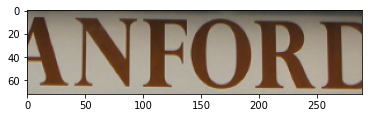

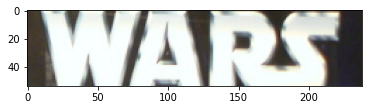

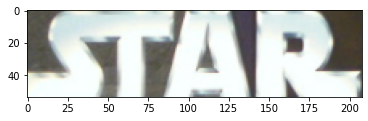

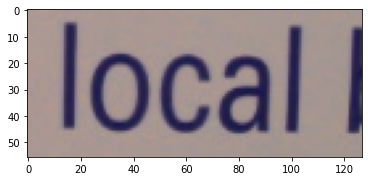

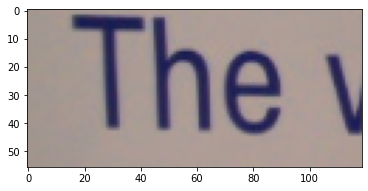

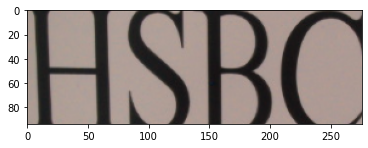

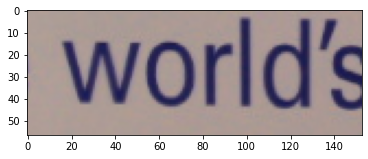

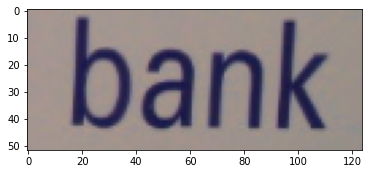

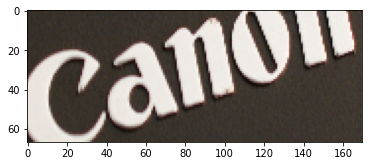

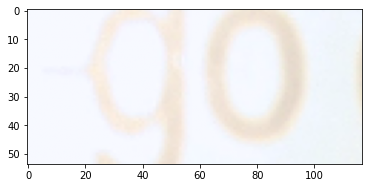

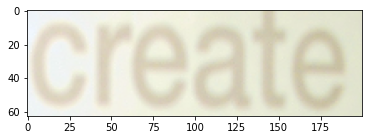

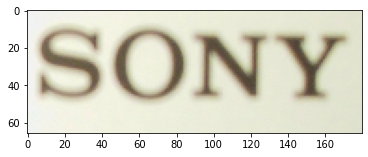

In [ ]:
#Showing CROPPED IMAGES. 
print(len(cropped_images))
for i in range (len(cropped_images)):
  plt.imshow(cropped_images[i])
  plt.show()

In [ ]:
def cnnModel(inputSize):
  inp = Input(inputSize)
  mdl = keras.layers.Sequential()
  mdl.add(Conv2D(input_shape=inp,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  mdl.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  mdl.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  mdl.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  mdl.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  mdl.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  mdl.add(Flatten())
  mdl.add(Dense(units=4096,activation="relu"))
  mdl.add(Dense(units=4096,activation="relu"))
  mdl.add(Dense(units=2, activation="softmax"))
  return mdl

In [ ]:
#gussuian Heat map 1
def gaussian_heatmap(sigma: int, spread: int):
    extent = int(spread * sigma)
    center = spread * sigma / 2
    heatmap = np.zeros([extent, extent], dtype=np.float32)
    for i_ in range(extent):
        for j_ in range(extent):
            heatmap[i_, j_] = 1 / 2 / np.pi / (sigma ** 2) * np.exp(
                -1 / 2 * ((i_ - center - 0.5) ** 2 + (j_ - center - 0.5) ** 2) / (sigma ** 2))
    heatmap = (heatmap / np.max(heatmap) * 255).astype(np.uint8)
    return heatmap

In [ ]:
def guass(image, image_w, image_h): 
  # Probability as a function of distance from the center derived
# from a gaussian distribution with mean = 0 and stdv = 1
  scaledGaussian = lambda x : exp(-(1/2)*(x**2))


  #imgSize = 512
  isotropicGrayscaleImage = np.zeros((image_w, image_h), np.uint8)
  #isotropicGrayscaleImage = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  for i in range(image_w):
    for j in range(image_h):

    # find euclidian distance from center of image (imgSize/2,imgSize/2) 
    # and scale it to range of 0 to 2.5 as scaled Gaussian
    # returns highest probability for x=0 and approximately
    # zero probability for x > 2.5

      distanceFromCenter = np.linalg.norm(np.array([i-image_w/2,j-image_h/2]))
      distanceFromCenter = 2.5*distanceFromCenter/(image_w/2)
      scaledGaussianProb = scaledGaussian(distanceFromCenter)
      isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)

    # Convert Grayscale to HeatMap Using Opencv
    isotropicGaussianHeatmapImage = cv2.applyColorMap(isotropicGrayscaleImage, 
                                                  cv2.COLORMAP_JET)
    return isotropicGaussianHeatmapImage

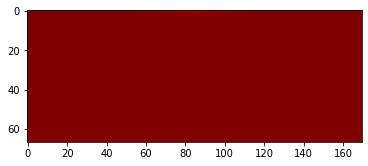

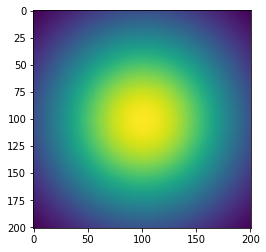

In [ ]:
#trial 
s = 8
image = cropped_images[s]
image = guass(image, cropped_images[s].shape[0], cropped_images[s].shape[1])
plt.imshow(image)
plt.show()

image = gaussian_heatmap(image.shape[0],3)
plt.imshow(image)
plt.show()

In [ ]:
def paste(background,foreground,pos=(0,0)):
    #get position and crop pasting area if needed
    x = pos[0]
    y = pos[1]
    bgWidth = background.shape[0]
    bgHeight = background.shape[1]
    frWidth = foreground.shape[0]
    frHeight = foreground.shape[1]
    width = bgWidth-x
    height = bgHeight-y
    if frWidth<width:
        width = frWidth
    if frHeight<height:
        height = frHeight
    # normalize alpha channels from 0-255 to 0-1
    alpha_background = background[x:x+width,y:y+height,3] / 255.0
    alpha_foreground = foreground[:width,:height,3] / 255.0
    # set adjusted colors
    for color in range(0, 3):
        fr = alpha_foreground * foreground[:width,:height,color]
        bg = alpha_background * background[x:x+width,y:y+height,color] * (1 - alpha_foreground)
        background[x:x+width,y:y+height,color] = fr+bg
    # set adjusted alpha and denormalize back to 0-255
    background[x:x+width,y:y+height,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255
    return background

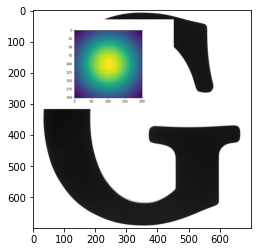

In [ ]:
#applying guass to letter g trial 

g = plt.imread('/root/g.jpg')

#g = paste(g, image)


#x_offset=y_offset=50
#g[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image

g = Image.open('/root/g.jpg')
ff = Image.open('/root/gs.jpg')
g.paste(ff, (20,30))

plt.imshow(g)
plt.show()